In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from dotenv import load_dotenv
import re
load_dotenv()

True

In [3]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
expense_log = []    

In [5]:
@tool
def log_expense(entry: str) -> str:
    """
    Extracts amount and category from text and logs the expense.
    """
    matches = re.findall(r"\$?(\d+(?:\.\d{1,2})?)\s*(?:on|for)?\s*(\w+)", entry.lower())
    if not matches:
        return "Could not parse any expenses."

    for amount, category in matches:
        expense_log.append((category, float(amount)))

    return f"Logged {len(matches)} expense(s)."

@tool
def get_total_spending(category: str = "") -> str:
    """
    Returns the total spending across all or one category.
    """
    if category:
        total = sum(amt for cat, amt in expense_log if cat == category.lower())
        return f"Total spent on {category}: ${total:.2f}"
    else:
        total = sum(amt for _, amt in expense_log)
        return f"Total spent so far: ${total:.2f}"


In [6]:
tools = [log_expense, get_total_spending]
llm =  ChatOpenAI()
llm_with_tools = llm.bind_tools(tools)
def assistant(state: State) -> State:
    result = llm_with_tools.invoke(state["messages"])
    return {"messages": [result]}


In [ ]:
builder = StateGraph(State)
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
    {
        "tools": "tools",
        "__end__": END
    }
)
builder.add_edge("tools", "assistant")

graph = builder.compile()

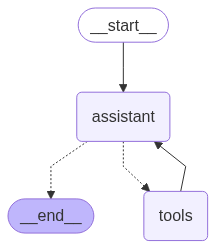

In [8]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Add some expenses
print("\n Logging multiple expenses...")
state = graph.invoke({
    "messages": [{"role": "user", "content": "I spent $30 on groceries and $15 on snacks today."}]
})
print(state["messages"][-1].content)

# Add another expense
print("\n Add coffee expense...")
state = graph.invoke({
    "messages": [{"role": "user", "content": "Log $8 on coffee."}]
})
print(state["messages"][-1].content)

# Ask total spent
print("\n Ask total...")
state = graph.invoke({
    "messages": [{"role": "user", "content": "What's my total spending?"}]
})
print(state["messages"][-1].content)

# Ask for category-wise spending
print("\n Ask spending on snacks...")
state = graph.invoke({
    "messages": [{"role": "user", "content": "How much did I spend on snacks?"}]
})
print(state["messages"][-1].content)

# General knowledge — LLM only
print("\n Ask general question...")
state = graph.invoke({
    "messages": [{"role": "user", "content": "Who founded OpenAI?"}]
})
print(state["messages"][-1].content)


 Logging multiple expenses...
[HumanMessage(content='I spent $30 on groceries and $15 on snacks today.', additional_kwargs={}, response_metadata={}, id='1b979d6c-bc70-4516-b661-8e2b8b53631a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_CetsiyPNpGG2ymGyRWZtHMDC', 'function': {'arguments': '{"entry": "$30 on groceries"}', 'name': 'log_expense'}, 'type': 'function'}, {'id': 'call_9SSwyujmcIH5tZ2KhFdYpMXC', 'function': {'arguments': '{"entry": "$15 on snacks"}', 'name': 'log_expense'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 96, 'total_tokens': 147, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BoFylyQ5fjgA2RYDSQbFp3Ck4A8AN', 'service_tier': 'default',